## Coding 3 - Final Assignment - _Patrik Szigeti_

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
from bs4 import BeautifulSoup

### Load the dataset

As the starting point for my analysis, I've used the [Video Game Sales](https://www.kaggle.com/gregorut/videogamesales) dataset from Kaggle, that contains a list of video games with sales greater than 100,000 copies across all regions.

In [2]:
vgsales = pd.read_csv('vgsales.csv', index_col=0)
vgsales.columns = vgsales.columns.str.lower()
vgsales.head(5)

,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


### Data Wrangling

#### Check for duplicated values

In [3]:
vgsales[vgsales.duplicated(keep=False)]

,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
Rank,,,,,,,,,,
15000,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,Nintendo,0.0,0.0,0.02,0.0,0.02
15002,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,Nintendo,0.0,0.0,0.02,0.0,0.02


There is one duplicated value, _Wii de Asobu: Metroid Prime_ appears on the list as both 15,000th and 15,002nd based on overall sales, which is not possible. I decided to drop the second appearance. (_Note:_ The kept record is later dropped due to missing year information.)

In [4]:
vgsales.drop_duplicates(keep='first', inplace=True)

#### Check for missing values

In [5]:
vgsales_columns_with_missing_data = vgsales.columns[vgsales.isnull().any()].tolist()
print('Columns with missing data in the vgsales dataframe are:\n{}\n'.format(', '.join(vgsales_columns_with_missing_data)))

for c in vgsales_columns_with_missing_data:
    print('The number of missing values in ' + c + ' is ' + str(vgsales[c].isnull().sum()))

Columns with missing data in the vgsales dataframe are:
year, publisher

The number of missing values in year is 270
The number of missing values in publisher is 58


`year` is the year of the game's release, while `publisher` is the publisher of the game.<br>
I can't use the average for `year`, as that would be misleading and incorrect, and there's no way to infer the `publisher` given its textual values, so I decided to drop any rows where either the year or the publisher is missing. This was only a small portion of the data considering the number of missing values.

In [6]:
vgsales.dropna(subset=['year', 'publisher'], inplace=True)

### Data description

In [7]:
vgsales.dtypes

name             object
platform         object
year            float64
genre            object
publisher        object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
global_sales    float64
dtype: object

`year` is `float64` because it used to have missing values, but it can be cast to `int` now.

In [8]:
vgsales['year'] = vgsales['year'].astype(int)

#### Describe the numeric columns

In [9]:
vgsales.describe()

,year,na_sales,eu_sales,jp_sales,other_sales,global_sales
count,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000
mean,2006.405561,0.265647,0.147731,0.078833,0.048426,0.540910
std,5.832412,0.822432,0.509303,0.311879,0.190083,1.567345
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


- The earliest game release from the list based on `year` is from 1980, while the latest is from 2020.
- In terms of sales, the minimums are 0 in a lot of cases, which is expected, since the dataset contains video games with `global_sales` over 100,000 copies (all sales data is in millions).
- Based on the mean and max values, most sales come from North America (`na_sales`), followed by Europe (`eu_sales`) and Japan (`jp_sales`).

In [10]:
vgsales[vgsales['na_sales']==vgsales['na_sales'].max()]

,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74


In [11]:
vgsales[vgsales['eu_sales']==vgsales['eu_sales'].max()]

,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74


In [12]:
vgsales[vgsales['jp_sales']==vgsales['jp_sales'].max()]

,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
Rank,,,,,,,,,,
5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.0,31.37


Based on the dataset, both in North America and Europe, _Wii Sports_ is the most sold video game, while in Japan, it's _Pokemon Red/Pokemon Blue_ from 1996. It's interesting to see that all of these are Nintendo's products (GB stands for Game Boy).

#### Describe the non-numeric columns

In [13]:
vgsales['platform'].value_counts()[:5]

DS      2131
PS2     2127
PS3     1304
Wii     1290
X360    1234
Name: platform, dtype: int64

In [14]:
vgsales['genre'].value_counts()[:5]

Action          3251
Sports          2304
Misc            1686
Role-Playing    1470
Shooter         1282
Name: genre, dtype: int64

In [15]:
vgsales['publisher'].value_counts()[:5]

Electronic Arts                 1339
Activision                       966
Namco Bandai Games               928
Ubisoft                          918
Konami Digital Entertainment     823
Name: publisher, dtype: int64

- Based on the dataset, most of the video games were released to Nintendo DS platform, followed closely by PlayStation 2. While both Nintendo and Sony have two console generations in the top 4, Microsoft with the Xbox 360 is only in the fifth place.
- Most of the games in this list are either action or sports games. "Misc" is for games that can't be forced into one category or the other.
- The publishers with the most games in this list are Electronic Arts and Activision.

### Extreme values

* Out of the 10 columns that I have in my dataset, 4 are objects, `name` is the name of the video game, while `platform`, `genre` and `publisher` are different categorizations of the data.
* The remaining 6 columns are numeric, but `year` is yet another dimension.
* Which leaves me with 5 measures that are worth exploring and creating a chart for - all of the `*_sales` figures for the different regions and altogether.

#### Create a list of all the `sales` measures

In [16]:
sales_measures = []
for col in vgsales.columns:
    if len(re.findall('sales', col)) > 0:
        sales_measures.append(col)

#### Explore the `sales` measures

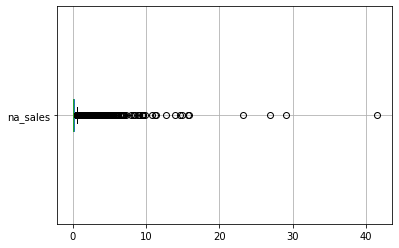

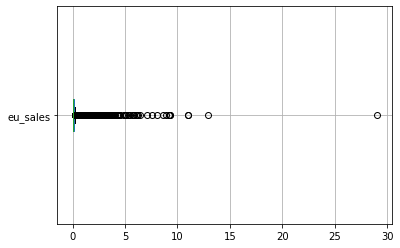

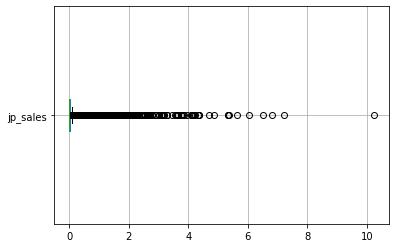

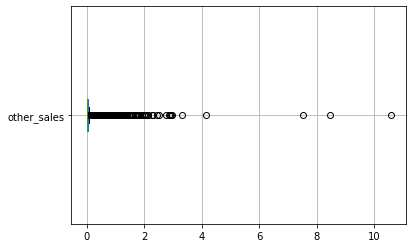

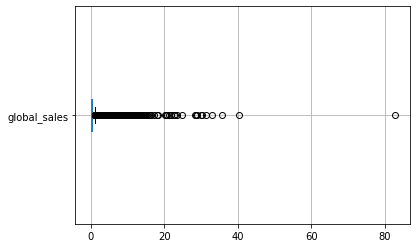

In [17]:
for m in sales_measures:
    vgsales.boxplot(m, vert=False)
    plt.show()

It seems like there's one extreme value for each sales measure, let's take a look at what they are.

In [18]:
for m in sales_measures:
    extreme_value = vgsales[vgsales[m] == vgsales[m].max()][['name', m]]
    print('The extreme value for ' + m + ' is ' 
          + extreme_value.iloc[0]['name'] + ' with ' + str(extreme_value.iloc[0][m]) + '.')

The extreme value for na_sales is Wii Sports with 41.49.
The extreme value for eu_sales is Wii Sports with 29.02.
The extreme value for jp_sales is Pokemon Red/Pokemon Blue with 10.22.
The extreme value for other_sales is Grand Theft Auto: San Andreas with 10.57.
The extreme value for global_sales is Wii Sports with 82.74.


By looking at the extreme values, we can see that they all make sense actually.
* From the data exploration above, it's obvious that _Wii Sports_ is the best selling game according to the dataset, its `global_sales` is at 82.74M copies, largely thanks to its North American (`na_sales`) and European (`eu_sales`) performance.
* _Pokemon Red/Pokemon Blue_ is the best selling game in the Japan region.
* _GTA: San Andreas_ perfomed the best in all other locations.

These are all valid numbers, the extreme value only means that they were/are popular and sold a huge number of copies.

No modifications are necessary, **I'm keeping all values in my dataset.**

> __Question 1:__ Is there a relative difference between the three regions (North America, Europe, Japan) in video game sales when it comes to different genres?

In order to answer the question, I'm sub-sampling the `vgsales` dataset to focus on `genre`, `na_sales`, `jp_sales` and `eu_sales`. By setting the index to `genre`, I can create a long formatted table instead of wide, and this way I can group by `region` and `genre` to create `copies_sold` that is an aggregate of all copies sold in each region per genre. I'm also renaming the sales features for better interpretability on the visualization.

In [19]:
q1 = vgsales[['genre', 'na_sales', 'jp_sales', 'eu_sales']].set_index('genre').unstack().reset_index().rename(
    columns={'level_0': 'region', 0: 'copies'}).groupby(['region', 'genre']).agg(
    copies_sold=('copies', 'sum')).reset_index().replace(
    {'eu_sales': 'Europe', 'na_sales': 'North America', 'jp_sales': 'Japan'})
q1.head()

,region,genre,copies_sold
0,Europe,Action,516.48
1,Europe,Adventure,63.74
2,Europe,Fighting,100.00
3,Europe,Misc,211.77
4,Europe,Platform,200.65


Text(0.5, 1.05, '# of copies sold by region and genre')

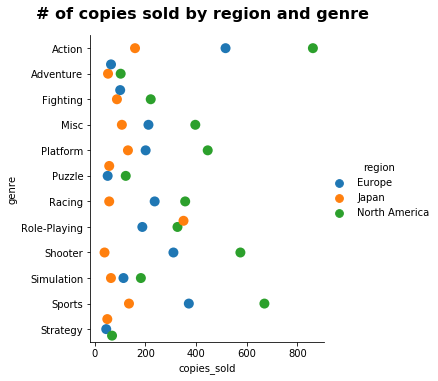

In [20]:
sns.catplot(data=q1, x='copies_sold', y='genre', hue='region', kind='swarm', s=10).fig.suptitle(
    '# of copies sold by region and genre', y=1.05, fontsize=16, weight='bold')

* Looking at the distribution of copies sold between different genres and regions, it's apparent that most of the sales happen in North America regardless of the genre, with only one exception: Role-Playing games.
* Role-Playing also seems to be the only extreme value in case of sales in Japan, all other categories are between 0 and 200 million sold copies, while this is nearly at 400.
* According to the dataset, the sales in North America follow a very different shape than Japan, with some genres really sticking out (e.g. Action, Shooter and Sports), and some with really low numbers (e.g. Adventure, Puzzle or Strategy).
* For Europe, the copies sold are between 0 and 400 million, and only the Action genre seems to be over-represented, the distribution is pretty normal otherwise.

To answer the question, I believe it's fair to say that there's a difference in costumer behaviour in the three regions overall, but also with regards to genres.

### Enrich the data

#### API

I'm using the [RAWG Video Games Database API](https://rawg.io/apidocs), which is the largest video game database and game discovery service. They offer various endpoints, but this time I'm focusing on their `games` endpoint to extract additional information for the games based on their title:

* Release date (`results.released`)
* Metacritic score (`results.metacritic`)

_Note:_ It is possible that not all games will have a match in the database, as searching on names isn't too fortunate because of e.g. differing capitalization, usage of special characters etc. It can also happen that not all of them will have a Metacritic score.

In [21]:
len(vgsales['name'].unique())

11325

There are 11,325 different games in my current dataset, and due to the size of this I've decided to only search for games that have at least 5MM copies sold globally (`global_sales > 5`).

In [22]:
games = vgsales[vgsales['global_sales']>5]['name'].unique()
len(games)

177

In [23]:
game_api = 'https://api.rawg.io/api/games?search='
games_dict = {}

for game in games:
    game_resp = json.loads(requests.get(game_api+game).text)['results']
    
    games_metadata_dict = {}
    games_metadata_dict.update(
        {
            'release_date': game_resp[0]['released'],
            'metacritic_score': game_resp[0]['metacritic']
        }
    )
    
    games_dict.update({game: games_metadata_dict})

I created a dictionary with the following layout:

`{'name': {'release_date', 'metacritic_score'}}`

Where `name` is the name of the game from my original `sales` dataset, and `release_date` and `metacritic_score` are coming through the API calls.

* Convert the API dictionary to dataframe

In [24]:
games_dict_df = pd.DataFrame.from_dict(games_dict, orient='index').reset_index(level=0).rename(columns={'index':'name'})
games_dict_df.head()

,name,release_date,metacritic_score
0,Wii Sports,2006-11-19,NaN
1,Super Mario Bros.,1985-09-13,NaN
2,Mario Kart Wii,2008-04-27,NaN
3,Wii Sports Resort,2009-07-26,NaN
4,Pokemon Red/Pokemon Blue,1996-02-27,NaN


* Join `vgsales` and `games_dict_df`

In [25]:
game_sales = pd.merge(vgsales, games_dict_df, how='left', left_on='name', right_on='name')
game_sales.head()

,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,release_date,metacritic_score
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,2006-11-19,NaN
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,1985-09-13,NaN
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,2008-04-27,NaN
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,2009-07-26,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,1996-02-27,NaN


#### Scraping

I noticed that a lot of games are missing their `metacritic_score`, so I'm going directly to the source, [Metacritic](http://metacritic.com) with the same filtered dataset (`global_sales > 5`) to limit the number of attempts.

In [26]:
tmp_games = game_sales[game_sales['global_sales']>5]
missing_metacritic_score = tmp_games[pd.isnull(tmp_games['metacritic_score'])].reset_index(drop=True)
missing_metacritic_score[['name', 'platform', 'global_sales', 'metacritic_score']].head()

,name,platform,global_sales,metacritic_score
0,Wii Sports,Wii,82.74,NaN
1,Super Mario Bros.,NES,40.24,NaN
2,Mario Kart Wii,Wii,35.82,NaN
3,Wii Sports Resort,Wii,33.00,NaN
4,Pokemon Red/Pokemon Blue,GB,31.37,NaN


The links on Metacritic are constructed in a way that requires the platform as well as the name of the game without special characters and with hyphens instead of spaces. I'm adding a column to the dataset with the constructed URL.

* Create a function to take care of mappings and URL construction with the help of the `platform_dict` mapping dictionary

In [27]:
platform_dict = {
    'GBA': 'game-boy-advance', 
    'XB': 'xbox',
    'X360': 'xbox-360',
    'PS': 'playstation',
    'PS2': 'playstation-2',
    'PS3': 'playstation-3',
    'PS4': 'playstation-4',
    'N64': 'nintendo-64',
    'GC': 'gamecube',
    'WiiU': 'wii-u'
}

In [28]:
def construct_metacritic_url(platform, name):       
    # Platforms are not abbreviated, using the platform_dict mapping directory instead
    try:
        url_platform = platform_dict[platform]
    except KeyError:
        url_platform = platform
        
    # Names don't have special characters and use hyphens instead of spaces
    url_name = name.replace(' ', '-').replace('/', '-').replace('.', '')
        
    return('http://metacritic.com/game/'+url_platform.lower()+'/'+url_name.lower())

In [29]:
missing_metacritic_score['metacritic_url'] = missing_metacritic_score.apply(
    lambda x: construct_metacritic_url(x['platform'], x['name']), axis=1
)
missing_metacritic_score[['name', 'platform', 'metacritic_url']].head()

,name,platform,metacritic_url
0,Wii Sports,Wii,http://metacritic.com/game/wii/wii-sports
1,Super Mario Bros.,NES,http://metacritic.com/game/nes/super-mario-bros
2,Mario Kart Wii,Wii,http://metacritic.com/game/wii/mario-kart-wii
3,Wii Sports Resort,Wii,http://metacritic.com/game/wii/wii-sports-resort
4,Pokemon Red/Pokemon Blue,GB,http://metacritic.com/game/gb/pokemon-red-poke...


* Pull all available scores from Metacritic to a dictionary

In [30]:
header = {'User-agent': 'Mozilla/5.0'}
metacritic_dict = {}

for i in range(len(missing_metacritic_score)):
    meta_key = missing_metacritic_score['name'][i]
    
    time.sleep(np.random.uniform(1, 1.5))
    r = requests.get(missing_metacritic_score['metacritic_url'][i], headers=header)
    
    if r.status_code == 404:
        continue
    else:  
        xlarge_div = BeautifulSoup(r.text, 'html.parser').find_all('div', class_='xlarge')
        if len(xlarge_div) > 0:
            meta_score = xlarge_div[0].text  
        else:
            meta_score = None
        
        metacritic_dict.update({meta_key: meta_score})

* Overwrite the missing scores from the scraped dictionary

In [31]:
def fill_metascore(name, metacritic_score):
    try:
        metascore = metacritic_dict[name]
    except KeyError:
        metascore = metacritic_score

    return(metascore)

In [32]:
game_sales['metacritic_score'] = game_sales.apply(lambda x: fill_metascore(x['name'], x['metacritic_score']), axis=1)
game_sales.head()

,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,release_date,metacritic_score
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,2006-11-19,76
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,1985-09-13,NaN
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,2008-04-27,82
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,2009-07-26,80
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,1996-02-27,NaN


> __Question 2:__ Is there a clear correlation between the number of copies sold and a game's Metacritic score?

In order to answer the question, I will only need `name`, `global_sales` and `metacritic_score` from my dataset, and far less data manipulation than for my first question. I'm also dropping all values that have no Metacritic scores.

In [33]:
q2 = game_sales[['name', 'global_sales', 'metacritic_score']].dropna().reset_index(drop=True)
q2['metacritic_score'] = q2['metacritic_score'].astype(float)
q2.head()

,name,global_sales,metacritic_score
0,Wii Sports,82.74,76.0
1,Mario Kart Wii,35.82,82.0
2,Wii Sports Resort,33.00,80.0
3,New Super Mario Bros.,30.01,89.0
4,Wii Play,29.02,58.0


Text(0.5, 1.05, 'Relationship between # of copies sold and Metacritic score')

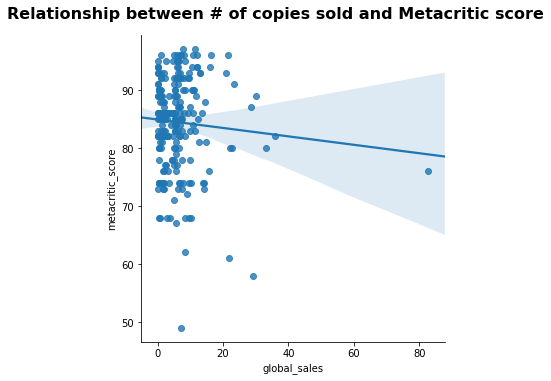

In [34]:
sns.lmplot(data=q2, x='global_sales', y='metacritic_score').fig.suptitle(
    'Relationship between # of copies sold and Metacritic score', y=1.05, fontsize=16, weight='bold')

It's clear from the chart that there's no correlation between how many copies a certain game sold, and how well it is ranked on Metacritic.

* Some of the best scored games have barely sold 20M copies worldwide, which further proves that quality is more important than quantity.
* The best selling game - which we know is _Wii Sports_ - only received a score of 76, which is considered mediocre.

Again, this illustrates that selling more copies won't result in a better score, there's no correlation.